In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

## Bulding a simple model

Let's start with the simplest problem of all: Bayesian estimation of the mean and variance from a sample of data points. Our model is:
$$
\begin{align}
    \mu &\sim \mathcal{N}(0, 3)\\
    \sigma^2 &\sim \text{Inv-Gamma}(1, 1)\\
    y_n &\sim \mathcal{N}(\mu, \sigma^2) \quad \text{for} \,\, n = 1,\dots,N
\end{align}
$$

In [4]:
### Simulate data
mu = 2.5
sigma = 3
N = 50
y = np.random.normal(mu, sigma, size=N)

<AxesSubplot: ylabel='Count'>

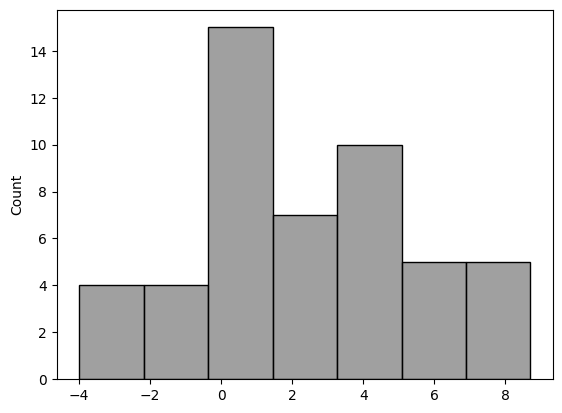

In [5]:
sns.histplot(y, color='gray')

In [6]:
### Create data dictionary
data_dict = {
    'y': y,
    'N': N
}

In [7]:
program_code = """

data {
    int<lower=1> N;
    vector[N] y;
}

parameters {
    real mu;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    mu ~ normal(0, 3);
    sigma2 ~ inv_gamma(1, 1);

    // Data model (likelihood)
    for (n in 1:N) {
        y[n] ~ normal(mu, sigma);
    }
}
"""

In [8]:
### Build model
model = stan.build(program_code, data=data_dict)

Building...



Building: found in cache, done.

In [9]:
### Fit model
fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)

Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 7.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000146 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
  Adjust your expectations accordingly!


In [10]:
### Explore raw model outouts
results_df = fit.to_frame()

In [11]:
results_df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma2,sigma
draws,,,,,,,,,,
0,-86.340864,1.000000,0.840526,2.0,3.0,0.0,87.198785,2.945363,9.766979,3.125217
1,-85.766361,0.862240,0.916259,2.0,3.0,0.0,87.255537,2.740079,9.622493,3.102014
2,-85.679039,1.000000,0.940878,2.0,3.0,0.0,85.880666,1.966999,10.800631,3.286431
3,-88.462911,0.999111,0.833059,3.0,7.0,0.0,89.785293,1.627043,7.020626,2.649646
4,-85.408277,0.911285,0.840526,1.0,3.0,0.0,87.137344,2.245844,10.732264,3.276014


In [12]:
results_df.shape

(4000, 10)

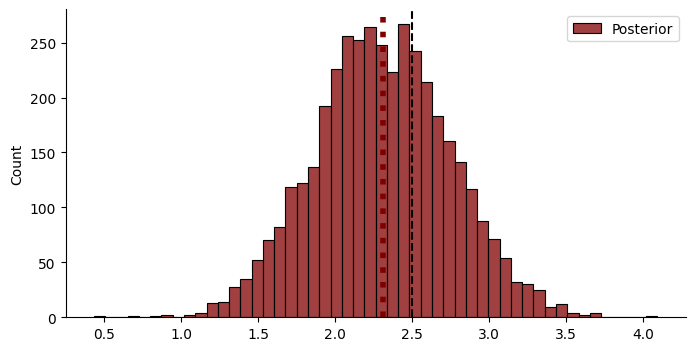

In [13]:
prior_samples = np.random.normal(0, 3, size=4000)
post_samples = results_df.mu.values
f, ax = plt.subplots(1, 1, figsize=(8, 4))
# sns.histplot(prior_samples, ax=ax, color="gray", alpha=0.8, label="Prior")
sns.histplot(post_samples, color='maroon', ax=ax, label="Posterior")
ax.axvline(np.mean(post_samples), color="maroon", linestyle="dotted", lw=4)
ax.axvline(mu, color="black", linestyle="dashed")
sns.despine(ax=ax)
ax.legend()

In [14]:
### Summarize model
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.308,0.441,1.476,3.123,0.008,0.006,3271.0,2427.0,1.0
sigma2,10.216,2.089,6.741,14.169,0.039,0.028,3006.0,2587.0,1.0
sigma,3.180,0.319,2.604,3.772,0.006,0.004,3006.0,2587.0,1.0


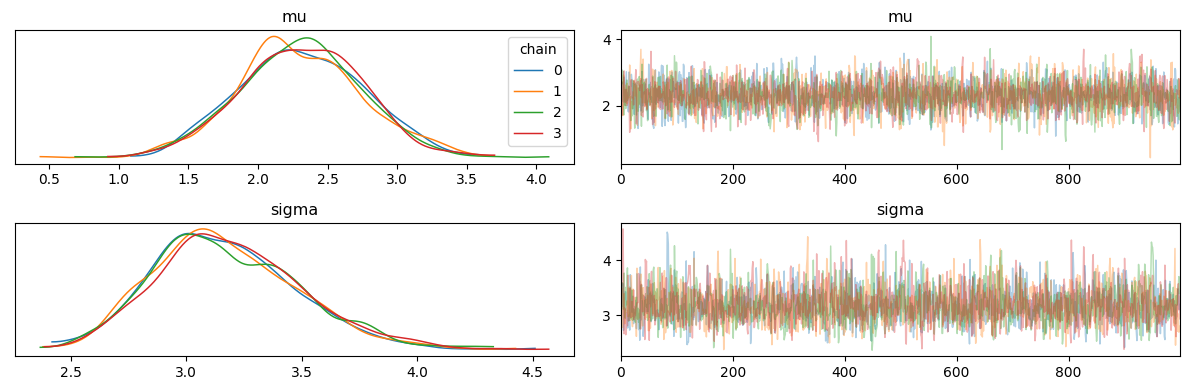

In [15]:
### Visual inspection and diagnostics
az.plot_trace(fit, var_names=['mu', 'sigma'], compact=False, legend=True)
plt.tight_layout()

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

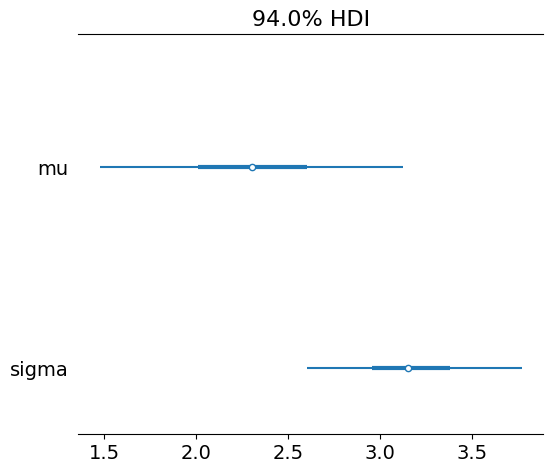

In [16]:
### Forest plots
az.plot_forest(fit, var_names=['mu', 'sigma'], combined=True)

Text(0, 0.5, '$\\sigma$')

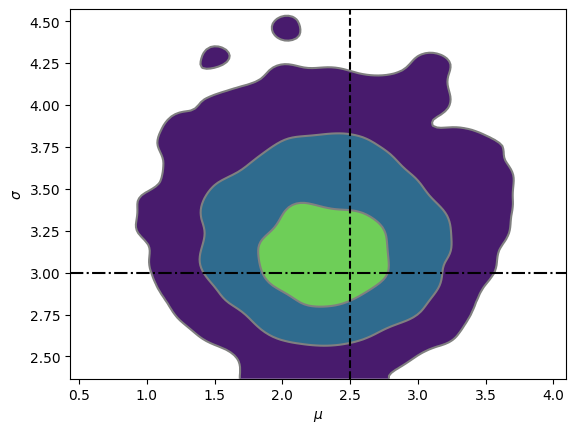

In [17]:
### Plot KDEs
ax = az.plot_kde(results_df.mu, 
                 results_df.sigma, hdi_probs=[0.393, 0.86, 0.99])
ax.axvline(mu, color='black', linestyle='--')
ax.axhline(sigma, color='black', linestyle='-.')
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\sigma$")

In [18]:
import pandas as pd

In [19]:
data = pd.read_csv("data_mot.csv", delimiter=";",header=0)

In [20]:
data.head()

,subj,trial,load,p_size
0,701,1,2,1021.408566
1,701,2,1,951.434880
2,701,3,5,1063.956947
3,701,4,4,913.487077
4,701,5,0,602.686850


In [21]:
mu = np.mean(data.p_size.values)
alpha = 100
beta = 100
sigma = np.std(data.p_size.values)

print("Mu: ", mu)
print("Sigma: ", sigma)

# x = np.linspace(0, 10, N)
# y = alpha + beta * x + np.random.normal(0, sigma, size=N)
# x = np.array(data["load"])
y = np.array(data.p_size.values)

Mu:  701.0583526909475
Sigma:  134.4058906295528


In [22]:
data_dict = {
    'y': data.p_size.values,
    # 'x': x,
    'N': len(data),
    # 'mu': mu,
    # 'sigma': sigma
}

In [23]:
program_code = """

data {
    int<lower=1> N;
    vector[N] y;
}

parameters {
    real mu;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    //mu ~ normal(900, 1100);
    //sigma2 ~ inv_gamma(1, 1);

    // Data model (likelihood)
    for (n in 1:N) {
        y[n] ~ normal(mu, sigma);
    }
} 

"""

In [24]:
print(data.shape)

(41, 4)


In [25]:
model = stan.build(program_code, data = data_dict)

Building...



Building: 121.7s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [26]:
fit = model.sample(num_chains=4, num_samples=1000, num_warmup=500)

Sampling:   0%
Sampling:  25% (1500/6000)
Sampling:  50% (3000/6000)
Sampling:  75% (4500/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
  Adjust your expectations accordingly!


In [27]:
### Summarize model
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,700.946,22.015,657.898,741.381,0.404,0.286,2983.0,2415.0,1.0
sigma2,20499.978,5154.745,11885.524,29818.348,98.038,72.732,3058.0,2284.0,1.0
sigma,142.131,17.288,111.490,174.369,0.322,0.233,3058.0,2284.0,1.0


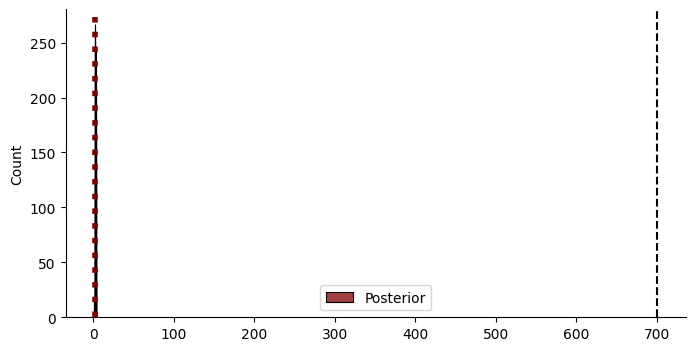

In [28]:
prior_samples = np.random.normal(0, 3, size=4000)
post_samples = results_df.mu.values
f, ax = plt.subplots(1, 1, figsize=(8, 4))
# sns.histplot(prior_samples, ax=ax, color="gray", alpha=0.8, label="Prior")
sns.histplot(post_samples, color='maroon', ax=ax, label="Posterior")
ax.axvline(np.mean(post_samples), color="maroon", linestyle="dotted", lw=4)
ax.axvline(mu, color="black", linestyle="dashed")
sns.despine(ax=ax)
ax.legend()

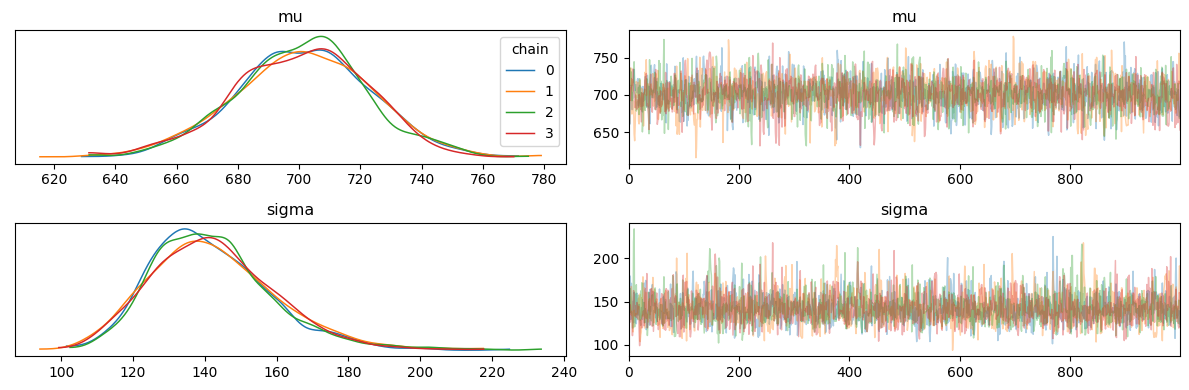

In [29]:
### Visual inspection and diagnostics
az.plot_trace(fit, var_names=['mu', 'sigma'], compact=False, legend=True)
plt.tight_layout()

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

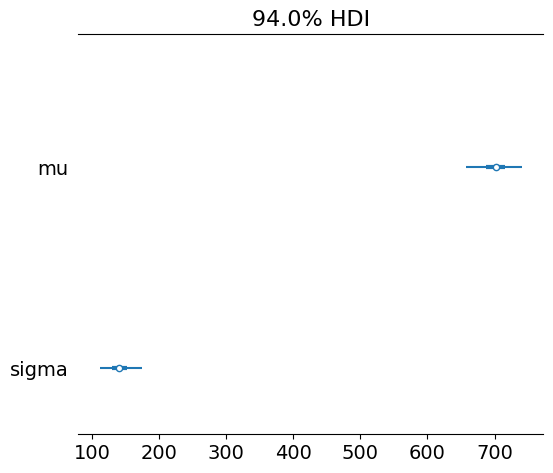

In [30]:
### Forest plots
az.plot_forest(fit, var_names=['mu', 'sigma'], combined=True)

Text(0, 0.5, '$\\sigma$')

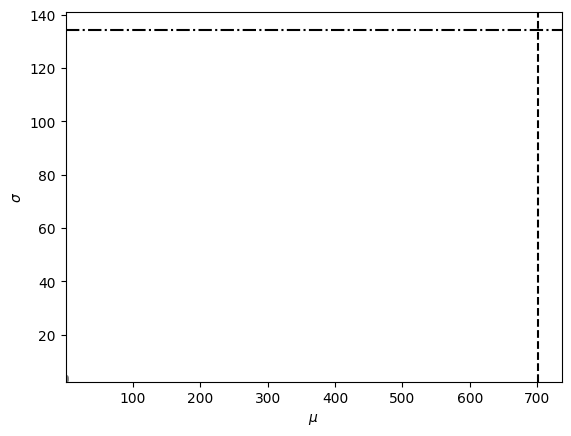

In [31]:
### Plot KDEs
ax = az.plot_kde(results_df.mu, 
                 results_df.sigma, hdi_probs=[0.393, 0.86, 0.99])
ax.axvline(mu, color='black', linestyle='--')
ax.axhline(sigma, color='black', linestyle='-.')
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\sigma$")

## Bayesian regression model

Next, we will build a simple Bayesian regression model of the form:
$$
\begin{align}
    \nonumber \sigma^2 &\sim \text{Inv-Gamma}(1, 1)\\
    \nonumber \alpha &\sim \mathcal{N}(0, 5)\\
    \nonumber \beta &\sim \mathcal{N}(0, 5)\\
\nonumber y_n &\sim \mathcal{N}(\alpha + \beta\,x_n, \sigma^2) \quad \text{for} \,\, n = 1,\dots,N
\end{align}
$$

In [ ]:
#### Your code here

program_code = """

data {
    int<lower=1> N;
    vector[N] y;
}

parameters {
    real mu;
    real<lower=0> sigma2;
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    //mu ~ normal(900, 1100);
    //sigma2 ~ inv_gamma(1, 1);

    // Data model (likelihood)
    for (n in 1:N) {
        y[n] ~ normal(mu, sigma);
    }
} 

"""

In [33]:
### Buld model
